In [ ]:
#@title Run this to download data and prepare our environment! { display-mode: "form" }
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

print("TensorFlow version: {}".format(tf.__version__))

# Load data
def load_cifar10():
  (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar10.load_data()
  y_train_cifar = y_train_cifar.squeeze()
  y_test_cifar = y_test_cifar.squeeze()
  return (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar)

# CIFAR100 classes
idx_to_class = ['background', 'car', 'truck']

# Construct vehicle dataset from CIFAR10
def construct_vehicle_dataset(data, labels, images_per_class, label_car=1, label_truck=9):
  mask_car = labels == label_car
  mask_truck = labels == label_truck

  mask_vehicles = mask_car | mask_truck
  mask_background = np.invert(mask_vehicles)
  
  data_car = data[mask_car]
  data_truck = data[mask_truck]
  data_background = data[mask_background][:images_per_class]

  new_data = np.vstack((data_background, data_car, data_truck))
  new_labels = np.repeat(np.array([0, 1, 2]), images_per_class, axis=0)
  
  return new_data, new_labels

def load_vehicle_dataset():
  (x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = load_cifar10()
  x_train, y_train = construct_vehicle_dataset(x_train_cifar, y_train_cifar, 5000)
  x_test, y_test = construct_vehicle_dataset(x_test_cifar, y_test_cifar, 1000)
  return (x_train, y_train), (x_test, y_test)

# Helper functions

# plotting
def plot_one_image(data, labels = [], index = None, image_shape = None):
  '''
  if data is a single image, display that image

  if data is a 4d stack of images, display that image
  '''
  ### cv2.imshow('image', data)    
  num_dims   = len(data.shape)
  num_labels = len(labels)
  if image_shape is not None:
    target_shape = image_shape
  else:
    target_shape = (32, 32, 3)
  # reshape data if necessary
  if num_dims == 1:
    data = data.reshape(target_shape)
  if num_dims == 2:
    data = data.reshape(np.vstack[-1, image_shape])
  num_dims   = len(data.shape)

  # check if single or multiple images
  if num_dims == 3:
    if num_labels > 1:
      print('Multiple labels does not make sense for single image.')
      return

    label = labels      
    if num_labels == 0:
      label = ''
    image = data

  if num_dims == 4:
    image = data[index, :]
    label = labels[index]

  # plot image of interest
  print('Label: %s'%label)
  plt.imshow(image)
  plt.show()

def model_to_string(model):
  import re
  stringlist = []
  model.summary(print_fn=lambda x: stringlist.append(x))
  sms = "\n".join(stringlist)
  sms = re.sub('_\d\d\d','', sms)
  sms = re.sub('_\d\d','', sms)
  sms = re.sub('_\d','', sms)  
  return sms

def normalize(data):
  # CIFAR100 mean (0.4914, 0.4822, 0.4465) std (0.2023, 0.1994, 0.2010)
  return (data/255-np.array((0.4914, 0.4822, 0.4465))) / np.array((0.2023, 0.1994, 0.2010))

def label_to_onehot(labels):
  final_labels = np.zeros((len(labels), 3))
  for i in range(len(labels)):
    label = labels[i]
    if label == 0:
      final_labels[i,:] = np.array([1, 0, 0])
    if label == 1:
      final_labels[i,:] = np.array([0, 1, 0])
    if label == 2:
      final_labels[i,:] = np.array([0, 0, 1])
  return final_labels

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
  # i'm sorry for this function's code. i am so sorry. 
  history = history.history
  history.update({'epoch':list(range(len(history['val_accuracy'])))})
  history = pd.DataFrame.from_dict(history)

  best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

  if not ax:
    f, ax = plt.subplots(1,1)
  sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
  sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
  ax.axhline(0.333, linestyle = '--',color='red', label = 'Chance')
  ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
  ax.legend(loc = 1)    
  ax.set_ylim([0.01, 1])

  ax.set_xlabel(xlabel)
  ax.set_ylabel('Accuracy (Fraction)')
  
  plt.show()



TensorFlow version: 2.7.0


In [ ]:
(x_train, y_train), (x_test, y_test) = load_vehicle_dataset()

170508288/170498071 [==============================] - 4s 0us/step


In [ ]:
print('Our labels are stored as %s in Python' % type(y_train))
print('The label vector of the training set has dimensions of (%d, )' % y_train.shape)
print('The label vector of the test set has dimensions of (%d, )' % y_test.shape)

Our labels are stored as <class 'numpy.ndarray'> in Python
The label vector of the training set has dimensions of (15000, )
The label vector of the test set has dimensions of (3000, )


In [ ]:
### YOUR CODE HERE
for item in idx_to_class:
  print(item)
### END CODE

background
car
truck


In [ ]:
import collections

### YOUR CODE HERE
counter = collections.Counter(y_train)
print(counter)
counter = collections.Counter(y_test)
print(counter)
### END CODE

Counter({0: 5000, 1: 5000, 2: 5000})
Counter({0: 1000, 1: 1000, 2: 1000})


In [ ]:
### YOUR CODE HERE
print(x_train.shape)
print(x_test.shape)
### END CODE

(15000, 32, 32, 3)
(3000, 32, 32, 3)


Label: ['background']


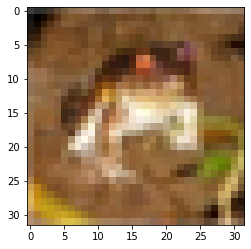

In [ ]:
# plot a SINGLE image
### YOUR CODE HERE
image = x_train[0]
label = [idx_to_class[y_train[0]]]
plot_one_image(image, label)
### END CODE

## Activity 1. Building networks

In [ ]:
# grab tools from our tensorflow and keras toolboxes!
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import optimizers

In [ ]:
# create our model by specifying and compiling it
model = Sequential()
model.add(Dense(4, input_shape=(3,),activation = 'relu'))
model.add(Dense(1, activation = 'linear'))
model.compile(loss='mean_squared_error',
                optimizer='adam',
                metrics=['mean_squared_error'])

In [ ]:
# grab tools from our tensorflow and keras toolboxes!
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras import optimizers

In [ ]:
# Fill in the blanks with your group!
### YOUR CODE HERE:
model_1 = Sequential()
model_1.add(Dense(4, input_shape=(3,),activation = 'relu'))
model_1.add(Dense(2, activation = 'softmax'))
model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['mean_squared_error'])
### END CODE

In [ ]:
perceptron = Sequential()
### FILL IN YOUR CODE HERE
perceptron.add(Flatten(input_shape = (32, 32, 3)))
perceptron.add(Dense(units = 128, activation = 'relu'))
perceptron.add(Dense(units = 3, activation = 'softmax'))
perceptron.compile(loss='categorical_crossentropy',
                optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.9),
                metrics=['accuracy'])### END CODE

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# define our monitor. Don't worry about the parameters here except for './model.h5' which is the file that our model saves to 
monitor = ModelCheckpoint('./model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# Normalize the data.
x_train_norm = normalize(x_train)
x_test_norm = normalize(x_test)

# Convert labels into one-hot numpy arrays.
y_train_onehot = label_to_onehot(y_train)
y_test_onehot = label_to_onehot(y_test)

### YOUR CODE HERE
history = perceptron.fit(x_train_norm, y_train_onehot, epochs = 20, validation_data = (x_test_norm, y_test_onehot), shuffle = True, callbacks = [monitor])
### END CODE

Epoch 1/20
469/469 [==============================] - 4s 6ms/step - loss: 0.8735 - accuracy: 0.6287 - val_loss: 0.7551 - val_accuracy: 0.6893
Epoch 2/20
469/469 [==============================] - 2s 5ms/step - loss: 0.6729 - accuracy: 0.7188 - val_loss: 0.7234 - val_accuracy: 0.6987
Epoch 3/20
469/469 [==============================] - 3s 5ms/step - loss: 0.6093 - accuracy: 0.7515 - val_loss: 0.6946 - val_accuracy: 0.7083
Epoch 4/20
469/469 [==============================] - 2s 5ms/step - loss: 0.5564 - accuracy: 0.7779 - val_loss: 0.7011 - val_accuracy: 0.7167
Epoch 5/20
469/469 [==============================] - 2s 5ms/step - loss: 0.5176 - accuracy: 0.7952 - val_loss: 0.6929 - val_accuracy: 0.7230
Epoch 6/20
469/469 [==============================] - 2s 5ms/step - loss: 0.4809 - accuracy: 0.8142 - val_loss: 0.6949 - val_accuracy: 0.7210
Epoch 7/20
469/469 [==============================] - 3s 6ms/step - loss: 0.4453 - accuracy: 0.8275 - val_loss: 0.7174 - val_accuracy: 0.7260
Epoch 

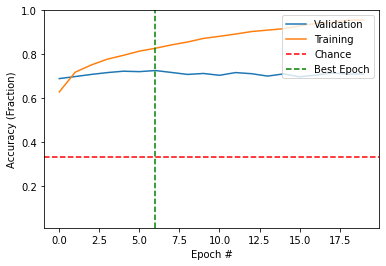

In [ ]:
### YOUR CODE HERE
plot_acc(history)

### END CODE